In [1]:
import pandas as pd

##  Load the dataset

In [2]:
df=pd.read_excel('Pubmed5k.xlsx')

In [3]:
df.head()

,ArticleID,Title,Abstract
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...


In [62]:
df['Abstract'][1]

'Clinical Scenario: Dynamic knee valgus (DKV) is a mechanical alteration in the knee that leads to increased risk of injury. Weakness of hip musculature in hip abduction (HABD), extension (HEXT), and external rotation (HER) may contribute to increased DKV in single-leg landing tasks. Focused Clinical Question: Is decreased hip strength associated with an increase in DKV during a single-leg landing task in collegiate female athletes? Summary of Key Findings: Three studies were included: One randomized control trial (RCT), one cohort study, and one case-control. All three studies found that decreases in HABD and HER strength contributed to increased DKV during single-leg landing tasks. One study also found that the hip extensors contribute to controlling hip adduction, a common factor in many mechanisms of injuries. These three studies recommended strengthening HABD, HEXT, and HER to decrease DKV and reduce the risk of injury at the knee. Clinical Bottom Line: Weak HABD, HEXT, and HER co

## explore the dataset

In [5]:
print("the length of the dataset is #{}".format(len(df)))
print("-"*100)
df.info()

the length of the dataset is #4999
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleID  4999 non-null   int64 
 1   Title      4999 non-null   object
 2   Abstract   4999 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


No null values

## Data Preprocessing ##

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


In [6]:
'''
Loading Gensim and nltk libraries
'''
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import PorterStemmer
import numpy as np
import nltk
nltk.download('wordnet')
print("All Done!")

All Done!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eslam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
'''
a function to perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return PorterStemmer().stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            # Apply lemmatize_stemming on the token, then add to the results list
            result.append(lemmatize_stemming(token))
    return result

In [8]:
# preprocess all the abstracts, saving the list of results as 'processed_docs'
processed_docs = df['Abstract'].map(preprocess)

In [9]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(processed_docs, min_count=20)
for idx in range(len(processed_docs)):
    for token in bigram[processed_docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            processed_docs[idx].append(token)

In [10]:
processed_docs[:10]

0    [coordin, variabl, commonli, analyz, understan...
1    [clinic, scenario, dynam, knee, valgu, mechan,...
2    [methodolog, report, assess, real, world, epid...
3    [outcom, acut, ischem, stroke, vari, accord, c...
4    [hear, loss, children, result, development, de...
5    [despit, grow, number, immigr, popul, exist, p...
6    [histor, treatment, lupu, nephriti, anti, neut...
7    [progress, chronic, kidney, diseas, individu, ...
8    [immunoglobulin, nephropathi, igan, common, pr...
9    [kidney, transplant, precis, medicin, enter, c...
Name: Abstract, dtype: object

## Step 3.1: Bag of words on the dataset

Now let's create a dictionary from 'processed_docs' containing the number of times a word appears in the training set. To do that, let's pass `processed_docs` to [`gensim.corpora.Dictionary()`](https://radimrehurek.com/gensim/corpora/dictionary.html) and call it '`dictionary`'.

In [11]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 achiev
1 analyz
2 approach
3 averag
4 awar
5 calcul
6 captur
7 cod
8 commonli
9 compar
10 consequ


** Gensim filter_extremes **

[`filter_extremes(no_below=5, no_above=0.5, keep_n=100000)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes)

Filter out tokens that appear in

* less than no_below documents (absolute number) or
* more than no_above documents (fraction of total corpus size, not absolute number).
* after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).

In [12]:
'''
Remove very rare and very common words:
- words appearing less than 20 times
- words appearing in more than 50% of all documents
'''
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)

In [13]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus =[dictionary.doc2bow(doc) for doc in processed_docs]

# TF-IDF "Term Frequency, Inverse Document Frequency

In [15]:
'''
Create tf-idf model object using models.TfidfModel on 'bow_corpus' and save it to 'tfidf'
'''
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)

In [16]:
'''
Apply transformation to the entire corpus and call it 'corpus_tfidf'
'''
corpus_tfidf = tfidf[bow_corpus]

In [17]:
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.05968680511283696),
 (1, 0.04647391767628489),
 (2, 0.04595837143765072),
 (3, 0.06567840682134847),
 (4, 0.08321528832514427),
 (5, 0.13246156338497458),
 (6, 0.09017806344652157),
 (7, 0.17355320973922284),
 (8, 0.07686488182520558),
 (9, 0.03132006862224852),
 (10, 0.07296289077080886),
 (11, 0.09354598288393255),
 (12, 0.1730718317785178),
 (13, 0.04162240798458448),
 (14, 0.028997032983833226),
 (15, 0.05371057622008804),
 (16, 0.09104562121364707),
 (17, 0.06418614242039895),
 (18, 0.0967564238158096),
 (19, 0.0439781512952881),
 (20, 0.19054043607892648),
 (21, 0.052745670783816236),
 (22, 0.07245897446757343),
 (23, 0.06977010595364098),
 (24, 0.04797876598052303),
 (25, 0.0470021055295063),
 (26, 0.0876915836055432),
 (27, 0.09134274922971987),
 (28, 0.08989647199054128),
 (29, 0.20590701962690977),
 (30, 0.09725579604808793),
 (31, 0.15183333025853496),
 (32, 0.19507967045473032),
 (33, 0.19428913672879858),
 (34, 0.07078268377793843),
 (35, 0.09456387805049615),
 (36,

In [ ]:
from gensim.models import CoherenceModel

# LDA Tuning: Finding the optimal number of topics
Finding the optimal number of topics in a topic model is tough, given that it is like a model hyperparameter that you always have to set before training the model. We can use an iterative approach and build several models with differing numbers of topics and select the one that has the highest coherence score.


In [20]:
def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1):
    models = []
    coherence_scores = []
    
    for topic_nums in range(start_topic_count, end_topic_count+1, step):
        
        lda_model = gensim.models.LdaModel(corpus, 
                                             num_topics=topic_nums, 
                                             id2word = dictionary,  
                                             alpha='auto',
                                             eta='auto')
                                             
        cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_lda.get_coherence()
        
        coherence_scores.append(coherence_score)
        
        models.append(lda_model)
    
    return models, coherence_scores

In [21]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=corpus_tfidf, texts=processed_docs,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1)

In [22]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df=coherence_df.sort_values(by=['Number of Topics'], ascending=True)
coherence_df.head()

,Number of Topics,Coherence Score
0,2,0.2501
1,3,0.3551
2,4,0.4156
3,5,0.4035
4,6,0.3287


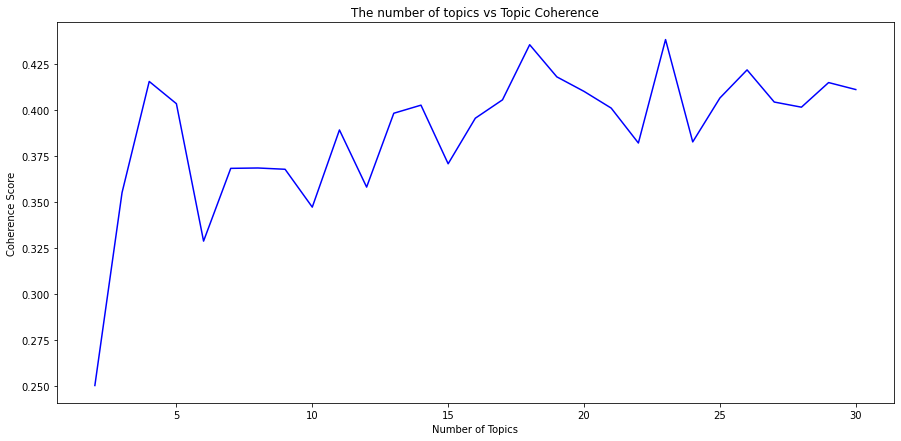

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
x_ax = coherence_df['Number of Topics']
y_ax = coherence_df['Coherence Score']
plt.figure(figsize=(15, 7));
plt.plot(x_ax, y_ax, c='b');
xl = plt.xlabel('Number of Topics');
yl = plt.ylabel('Coherence Score');
plt.title("The number of topics vs Topic Coherence");

# Final Model
Let’s train the final model using the above selected parameters

In [24]:
num_of_topics=coherence_df['Number of Topics'].values[coherence_df['Coherence Score']==np.max(coherence_df['Coherence Score'])]
print("The optimal number of topics are {} topics".format(int(num_of_topics)))

The optimal number of topics are 23 topics


In [70]:
lda_model =gensim.models.LdaModel(corpus_tfidf, 
                                             num_topics=23, 
                                             id2word = dictionary,  
                                             alpha='auto',
                                             eta='auto')

In [71]:
lda_model.show_topics(num_topics=23, num_words=10, log=False, formatted=True)

[(0,
  '0.009*"speci" + 0.005*"water" + 0.005*"wastewat" + 0.004*"transfer" + 0.004*"food" + 0.004*"devic" + 0.004*"fluoresc" + 0.004*"microbi" + 0.004*"field" + 0.004*"marin"'),
 (1,
  '0.012*"genu" + 0.006*"systemat_review" + 0.005*"cluster" + 0.005*"review" + 0.005*"plate" + 0.005*"search" + 0.005*"systemat" + 0.005*"cancer" + 0.004*"youth" + 0.004*"health_worker"'),
 (2,
  '0.012*"headach" + 0.007*"ventricular" + 0.007*"bird" + 0.007*"patient" + 0.006*"citat" + 0.006*"intracrani" + 0.006*"index" + 0.006*"infarct" + 0.005*"imag" + 0.005*"lymphoma"'),
 (3,
  '0.008*"sodium" + 0.007*"enzym" + 0.006*"workflow" + 0.006*"motion" + 0.006*"antioxid" + 0.006*"copd" + 0.005*"fall" + 0.005*"muscl" + 0.005*"toxic" + 0.004*"bond"'),
 (4,
  '0.008*"patient" + 0.006*"care" + 0.006*"health" + 0.005*"digit" + 0.004*"research" + 0.004*"profession" + 0.004*"particip" + 0.004*"month" + 0.004*"commun" + 0.004*"team"'),
 (5,
  '0.009*"cervic" + 0.008*"cost" + 0.008*"maxillari" + 0.007*"care" + 0.006*"de

In [72]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))
    print("\n")

Topic: 0 Word: 0.009*"speci" + 0.005*"water" + 0.005*"wastewat" + 0.004*"transfer" + 0.004*"food" + 0.004*"devic" + 0.004*"fluoresc" + 0.004*"microbi" + 0.004*"field" + 0.004*"marin"


Topic: 1 Word: 0.012*"genu" + 0.006*"systemat_review" + 0.005*"cluster" + 0.005*"review" + 0.005*"plate" + 0.005*"search" + 0.005*"systemat" + 0.005*"cancer" + 0.004*"youth" + 0.004*"health_worker"


Topic: 2 Word: 0.012*"headach" + 0.007*"ventricular" + 0.007*"bird" + 0.007*"patient" + 0.006*"citat" + 0.006*"intracrani" + 0.006*"index" + 0.006*"infarct" + 0.005*"imag" + 0.005*"lymphoma"


Topic: 3 Word: 0.008*"sodium" + 0.007*"enzym" + 0.006*"workflow" + 0.006*"motion" + 0.006*"antioxid" + 0.006*"copd" + 0.005*"fall" + 0.005*"muscl" + 0.005*"toxic" + 0.004*"bond"


Topic: 4 Word: 0.008*"patient" + 0.006*"care" + 0.006*"health" + 0.005*"digit" + 0.004*"research" + 0.004*"profession" + 0.004*"particip" + 0.004*"month" + 0.004*"commun" + 0.004*"team"


Topic: 5 Word: 0.009*"cervic" + 0.008*"cost" + 0.008*"

In [74]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_model.show_topic(n, topn=10)] 
                   for n in range(0, lda_model.num_topics)]
for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['speci', 'water', 'wastewat', 'transfer', 'food', 'devic', 'fluoresc', 'microbi', 'field', 'marin']

Topic #2:
['genu', 'systemat_review', 'cluster', 'review', 'plate', 'search', 'systemat', 'cancer', 'youth', 'health_worker']

Topic #3:
['headach', 'ventricular', 'bird', 'patient', 'citat', 'intracrani', 'index', 'infarct', 'imag', 'lymphoma']

Topic #4:
['sodium', 'enzym', 'workflow', 'motion', 'antioxid', 'copd', 'fall', 'muscl', 'toxic', 'bond']

Topic #5:
['patient', 'care', 'health', 'digit', 'research', 'profession', 'particip', 'month', 'commun', 'team']

Topic #6:
['cervic', 'cost', 'maxillari', 'care', 'dental', 'alcohol', 'incom', 'transport', 'caregiv', 'cost_effect']

Topic #7:
['potassium', 'stigma', 'speci', 'illustr', 'pneumonia', 'rescu', 'mammal', 'season', 'gene', 'calcium']

Topic #8:
['student', 'nurs', 'health', 'social', 'compet', 'print', 'particl', 'adolesc', 'dental', 'physic']

Topic #9:
['trait', 'speci', 'motiv', 'charact', 'japanes', 'spine', 'c

In [75]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(0, lda_model.num_topics)]
                         )
topics_df

<ipython-input-75-0df6d503e98d>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic0,"speci, water, wastewat, transfer, food, devic, fluoresc, microbi, field, marin"
Topic1,"genu, systemat_review, cluster, review, plate, search, systemat, cancer, youth, health_worker"
Topic2,"headach, ventricular, bird, patient, citat, intracrani, index, infarct, imag, lymphoma"
Topic3,"sodium, enzym, workflow, motion, antioxid, copd, fall, muscl, toxic, bond"
Topic4,"patient, care, health, digit, research, profession, particip, month, commun, team"
Topic5,"cervic, cost, maxillari, care, dental, alcohol, incom, transport, caregiv, cost_effect"
Topic6,"potassium, stigma, speci, illustr, pneumonia, rescu, mammal, season, gene, calcium"
Topic7,"student, nurs, health, social, compet, print, particl, adolesc, dental, physic"
Topic8,"trait, speci, motiv, charact, japanes, spine, carcinoma, person, genet, famili"
Topic9,"sar, gene, cell, covid, infect, protein, patient, express, viru, diseas"


In [76]:
doc_lda=lda_model[corpus_tfidf]

In [77]:
doc_lda[1]

[(14, 0.8626723)]

In [78]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])
                     for topics in doc_lda]


In [82]:
corpus_topics[3]

[(12, 0.5093128), (14, 0.21019512), (4, 0.18157525)]

In [83]:
new_df=pd.DataFrame(columns=['Abstract','Topic_1',"Topic_1_score",'Topic_2',"Topic_2_score",'Topic_3',"Topic_3_score"])
for i in range(len(df)):
    if len(corpus_topics[i])>=3:
        new_df = new_df.append({'Abstract':df["Abstract"][i],'Topic_1':corpus_topics[i][0][0],
                                'Topic_1_score':corpus_topics[i][0][1],
                                'Topic_2':corpus_topics[i][1][0],
                                'Topic_2_score':corpus_topics[i][1][1],
                               'Topic_3':corpus_topics[i][2][0],
                               'Topic_3_score':corpus_topics[i][2][1]},
                               ignore_index=True)
    elif len(corpus_topics[i])==2:
        new_df = new_df.append({'Abstract':df["Abstract"][i],'Topic_1':corpus_topics[i][0][0],
                        'Topic_1_score':corpus_topics[i][0][1],
                        'Topic_2':corpus_topics[i][1][0],
                        'Topic_2_score':corpus_topics[i][1][1],
                               'Topic_3':np.nan,
                               'Topic_3_score':np.nan},
                       ignore_index=True)
    else:
        new_df = new_df.append({'Abstract':df["Abstract"][i],'Topic_1':corpus_topics[i][0][0],
                                    'Topic_1_score':corpus_topics[i][0][1],
                                    'Topic_2':np.nan,
                                    'Topic_2_score':np.nan,
                                   'Topic_3':np.nan,
                                   'Topic_3_score':np.nan},
                                   ignore_index=True)       

In [84]:
new_df.head()

,Abstract,Topic_1,Topic_1_score,Topic_2,Topic_2_score,Topic_3,Topic_3_score
0,"Coordination variability (CV) is commonly analyzed to understand dynamical qualities of human locomotion. The purpose of this study was to develop guidelines for the number of trials required to inform the calculation of a stable mean lower limb CV during overground locomotion. Three-dimensional lower limb kinematics were captured for 10 recreational runners performing 20 trials each of preferred and fixed speed walking and running. Stance phase CV was calculated for 9 segment and joint couplings using a modified vector coding technique. The number of trials required to achieve a CV mean within 10% of 20 strides average was determined for each coupling and individual. The statistical outputs of mode (walking vs running) and speed (preferred vs fixed) were compared when informed by differing numbers of trials. A minimum of 11 trials were required for stable mean stance phase CV. With fewer than 11 trials, CV was underestimated and led to an oversight of significant differences between mode and speed. Future overground locomotion CV research in healthy populations using a vector coding approach should use 11 trials as a standard minimum. Researchers should be aware of the notable consequences of an insufficient number of trials for overall study findings.",13,0.877860,NaN,NaN,NaN,NaN
1,"Clinical Scenario: Dynamic knee valgus (DKV) is a mechanical alteration in the knee that leads to increased risk of injury. Weakness of hip musculature in hip abduction (HABD), extension (HEXT), and external rotation (HER) may contribute to increased DKV in single-leg landing tasks. Focused Clinical Question: Is decreased hip strength associated with an increase in DKV during a single-leg landing task in collegiate female athletes? Summary of Key Findings: Three studies were included: One randomized control trial (RCT), one cohort study, and one case-control. All three studies found that decreases in HABD and HER strength contributed to increased DKV during single-leg landing tasks. One study also found that the hip extensors contribute to controlling hip adduction, a common factor in many mechanisms of injuries. These three studies recommended strengthening HABD, HEXT, and HER to decrease DKV and reduce the risk of injury at the knee. Clinical Bottom Line: Weak HABD, HEXT, and HER contribute to increased DKV in college female athletes, but strengthening HABD, HEXT, and HER can lead to decreases in DKV and, overall, reduce the risk of injury at the knee. Strength of Recommendation: These articles were graded with a level of evidence of III or higher, giving a grade of B strength of recommendation that weak HABD, HEXT, and HER are associated with increased DKV in collegiate female athletes.",14,0.862673,NaN,NaN,NaN,NaN
2,"Various methodologies have been reported to assess the real-world epidemiology of amyotrophic lateral sclerosis (ALS) in the United States. The aim of this study was to estimate the prevalence, incidence, and geographical distribution of ALS using administrative claims data and to model future trends in ALS epidemiology.,We performed a retrospective analysis of deidentified administrative claims data for >100 million patients, using 2 separate databases (IBM MarketScan Research Databases and Symphony Health Integrated DataVerse [IDV]), to identify patients with ALS. We evaluated disease prevalence, annual incidence, age- and population-controlled geographical distribution, and expected future trends.,From 2013 to 2017, we identified 7,316 and 35,208 ALS patients from the MarketScan databases and IDV, respectively. Average annual incidence estimates were 1.48 and 1.37 per 100,000 and point prevalence estimates were 6.85 and 5.16 per 100,000 and in the United States for the MarketScan databases and IDV, respectively. Predictive modeling estimates are reported out to the year 2060 and demonstrate an increasing trend in both incident and prevalent cases.,T

In [85]:
new_df.to_csv("clustred_topics.csv")